# Project Name : QUORA QUESTION PAIR SIMILARITY

Main Aim : We need to predict whether a pair of questions are duplicate or not. 

# All the Lifecycle In A Data Science Projects

   1) Data Analysis
   2) Feature Engineering
   3) Feature Selection
   4) Model Building
   5) Model Deployment



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
from nltk.stem import WordNetLemmatizer

In [13]:
df = pd.read_csv("train.csv",nrows=202145)

print("Number of data points:",df.shape[0])

Number of data points: 202145


In [14]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202145 entries, 0 to 202144
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            202145 non-null  int64 
 1   qid1          202145 non-null  int64 
 2   qid2          202145 non-null  int64 
 3   question1     202145 non-null  object
 4   question2     202143 non-null  object
 5   is_duplicate  202145 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 9.3+ MB


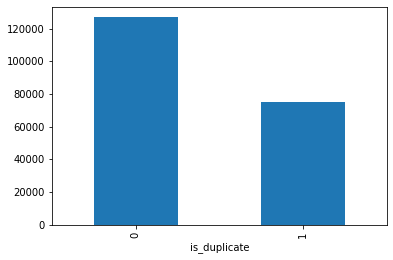

In [16]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [17]:
any_duplicates=df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(any_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


In [18]:
null_rows=df[df.isnull().any(1)]
null_rows

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [19]:
df=df.fillna('')
null_rows=df[df.isnull().any(1)]
null_rows

,id,qid1,qid2,question1,question2,is_duplicate


In [20]:
qid=pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
print('Numner of uniques questions are : {}'.format(len(np.unique(qid))))
print('Number of questions that appear more than once : {}'.format(np.sum(qid.value_counts()>1)))

Numner of uniques questions are : 304330
Number of questions that appear more than once : 48579


In [21]:
stop_words = stopwords.words("english")
stop_words.remove('not')
stop_words.remove('no')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very',

In [22]:
from fuzzywuzzy import fuzz
df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)

In [23]:
lemmat=WordNetLemmatizer()
def preprocess(x):
    k=[]
    x=x.lower().replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x=x=re.sub('[^a-zA-Z0-9]',' ',x)
    words=nltk.word_tokenize(x)
    words=[lemmat.lemmatize(word) for word in words if word not in stopwords.words('english')]
    k=' '.join(words)
    return k

In [24]:
df['question1']=df['question1'].apply(preprocess)
df['question2']=df['question2'].apply(preprocess)

In [25]:
df['q1len'] = df['question1'].str.len() 
df['q2len'] = df['question2'].str.len()

In [26]:
def word_common(x):
    w1=set(map(lambda word:word.lower().strip(),x['question1'].split(" ")))
    w2=set(map(lambda word:word.lower().strip(),x['question2'].split(" ")))
    return 1.0 * len(w1 & w2)

df['word_Common'] = df.apply(word_common, axis=1)


In [27]:
def word_total(x):
    w1=set(map(lambda word:word.lower().strip(),x['question1'].split(" ")))
    w2=set(map(lambda word:word.lower().strip(),x['question2'].split(" ")))
    return 1.0 * len(w1) + len(w2)

df['word_Total'] = df.apply(word_total, axis=1)

In [28]:
df['word_share']=df['word_Common']/df['word_Total']

In [29]:
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

In [30]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,q1len,q2len,word_Common,word_Total,word_share,q1_n_words,q2_n_words
0,0,1,2,step step guide invest share market india,step step guide invest share market,0,100,93,93,98,41,35,5.0,11.0,0.454545,7,6
1,1,3,4,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,0,86,63,66,73,31,67,4.0,15.0,0.266667,5,10
2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0,63,63,43,41,44,36,2.0,11.0,0.181818,6,5
3,3,7,8,mentally lonely solve,find remainder math 23 24 math divided 24 23,0,28,24,9,20,21,44,0.0,9.0,0.000000,3,9
4,4,9,10,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0,67,47,35,54,60,29,2.0,15.0,0.133333,10,5


In [31]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 2054
Number of Questions with minimum length [question2] : 2310


# Exploratory Data Analysis

# Word_share

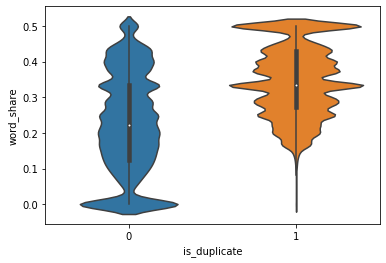

In [32]:
sns.violinplot(x=df['is_duplicate'],y=df['word_share'])
plt.show()

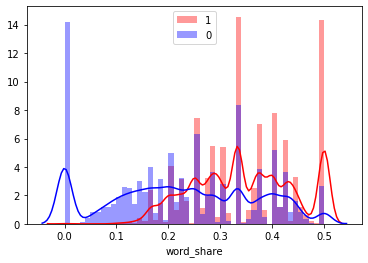

In [33]:
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.legend()
plt.show()

# Word_common

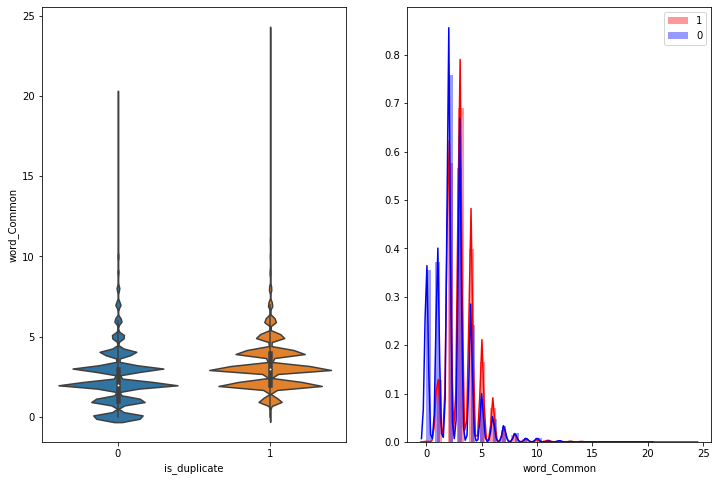

In [34]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.legend()
plt.show()

# Token Sort Ratio

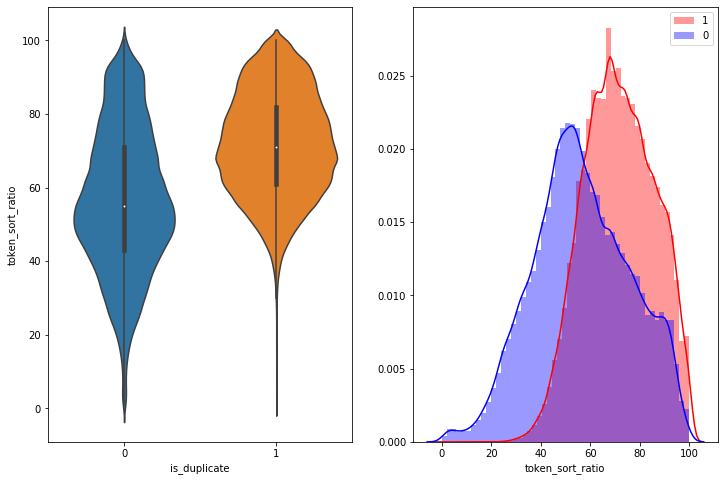

In [35]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.legend()
plt.show()

# Fuzz Ratio

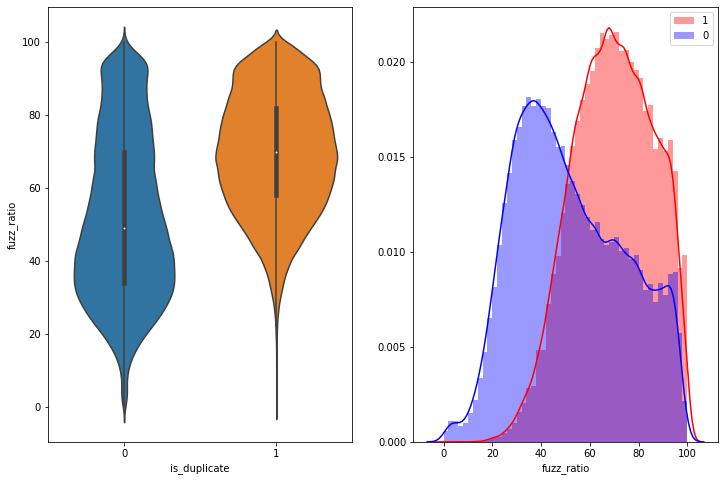

In [36]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.legend()
plt.show()

<Figure size 864x720 with 0 Axes>

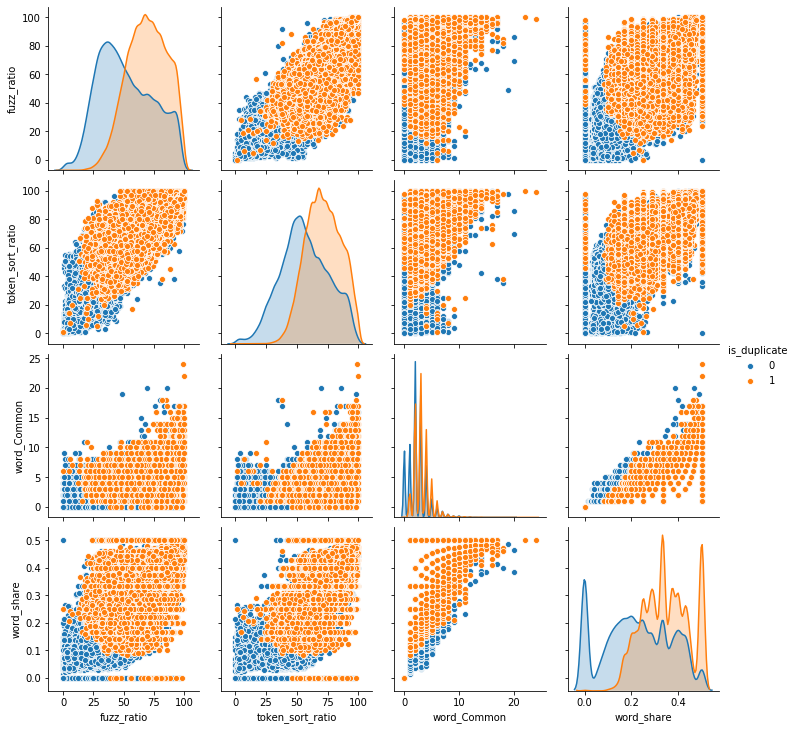

In [37]:
plt.figure(figsize=(12,10))
sns.pairplot(data=df,hue="is_duplicate",vars=['fuzz_ratio','token_sort_ratio','word_Common','word_share'])
plt.show()

In [38]:
file_path='training1.csv'
df.to_csv(file_path,index=False)